In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv("data-p2/patients_interactions_mimic3d.csv")
df.shape

(2976, 1597)

In [3]:
y = df["LOSdays"]

x1 = df['NumTransfers']
x2 = df['NumCallouts admit_type_EMERGENCY']
x3 = df['NumDiagnosis NumTransfers']
x4 = df['NumChartEvents admit_type_NEWBORN']
x5 = df['admit_type_NEWBORN admit_location_CLINIC REFERRAL/PREMATURE']

# x1 = df['NumCallouts']
# x2 = df['NumCallouts NumTransfers']
# x3 = df['NumRx AdmitProcedure_4']
# x4 = df['NumTransfers insurance_Private']
# x5 = df['NumChartEvents admit_type_NEWBORN']

# x1 = df["NumTransfers admit_type_EMERGENCY"]
# x2 = df["NumCallouts"]
# x3 = df["NumCallouts NumProcs"]
# x4 = df["NumTransfers insurance_Medicare"]
# x5 = df["NumTransfers insurance_Private"]

In [4]:
rng = np.random.default_rng(69)

with pm.Model() as model:
    intercept = pm.Normal('Intercept', mu=float(1.016e+01), sigma=100)
    slope_1 = pm.Normal('NumTransfers', mu=float(-1.469e+00), sigma=100)
    slope_2 = pm.Normal('Interaction Between NumCallouts and admit_type_EMERGENCY', mu=float(-1.424e+01), sigma=100)
    slope_3 = pm.Normal('Interaction Between NumDiagnosis and NumTransfers', mu=float(6.560e-03), sigma=100)
    slope_4 = pm.Normal('Interaction Between NumChartEvents and admit_type_NEWBORN', mu=float(1.465e-02), sigma=100)
    slope_5 = pm.Normal('Interaction Between admit_type_NEWBORN and admit_location_CLINIC REFERRAL/PREMATURE', mu=float(1.421e+01), sigma=100)
    
    sigma = pm.Exponential('Standard Deviation', lam=0.0001)
    
    mu = (intercept
          + slope_1 * x1 
          + slope_2 * x2
          + slope_3 * x3
          + slope_4 * x4
          + slope_5 * x5
    )
    
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(draws=10000, tune=5000,return_inferencedata=True, progressbar=True,random_seed=rng)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, NumTransfers, Interaction Between NumCallouts and admit_type_EMERGENCY, Interaction Between NumDiagnosis and NumTransfers, Interaction Between NumChartEvents and admit_type_NEWBORN, Interaction Between admit_type_NEWBORN and admit_location_CLINIC REFERRAL/PREMATURE, Standard Deviation]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 10 seconds.


In [5]:
mu_samples = trace.posterior['mu'].values.flatten()

hpd_interval = pm.hdi(mu_samples, hdi_prob=0.95)


KeyError: "No variable named 'mu'. Variables on the dataset include ['chain', 'draw', 'Intercept', 'NumTransfers', 'Interaction Between NumCallouts and admit_type_EMERGENCY', 'Interaction Between NumDiagnosis and NumTransfers', 'Interaction Between NumChartEvents and admit_type_NEWBORN', 'Interaction Between admit_type_NEWBORN and admit_location_CLINIC REFERRAL/PREMATURE', 'Standard Deviation']"

In [ ]:
trace_df = az.extract(trace).to_dataframe()

trace_df.to_csv('data-p2/trace_output.csv', index=False)

In [ ]:
import re

var_names = list(trace.posterior.data_vars)

for var in var_names:
    safe_var_name = re.sub(r'[\\/:*?"<>| ]', '_', var)
    axes = az.plot_trace(
        trace, 
        var_names=[var],
        figsize=(22, 5), 
        plot_kwargs={'alpha': 0}, 
        fill_kwargs={'alpha': 0.5, 'color': '#63afd3'}
    )

    for ax in axes[:, 1]:
        for line in ax.get_lines():
            line.set_color('#41825d')

    for ax in axes.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        ax.tick_params(axis='both', which='both', colors='gray')

    var_data = trace.posterior[var].values.flatten() 

    axes[0, 0].axvline(hdi_bounds[0], color='red', linestyle='--', linewidth=1.0, label='95% HDI')
    axes[0, 0].axvline(hdi_bounds[1], linestyle='--', color='red', linewidth=1.0)

    axes[0, 0].set_xlabel("Estimate", color='#4d4d4d')
    axes[0, 0].set_ylabel("Density", color='#4d4d4d')
    axes[0, 0].set_title(f"Posterior of {var}", color='#4d4d4d', fontsize=11)
    axes[0, 0].yaxis.set_major_locator(plt.MaxNLocator())

    axes[0, 1].set_title(f"Chain Values of {var}", color='#4d4d4d', fontsize=11)
    axes[0, 1].set_xlabel("Index", color='#4d4d4d')
    axes[0, 1].set_ylabel("Sample Value", color='#4d4d4d')

    plt.savefig(f'trace_plots/trace_plot_{safe_var_name}.png', format='png', bbox_inches='tight', transparent=False, dpi=600)
    plt.close()  

: 

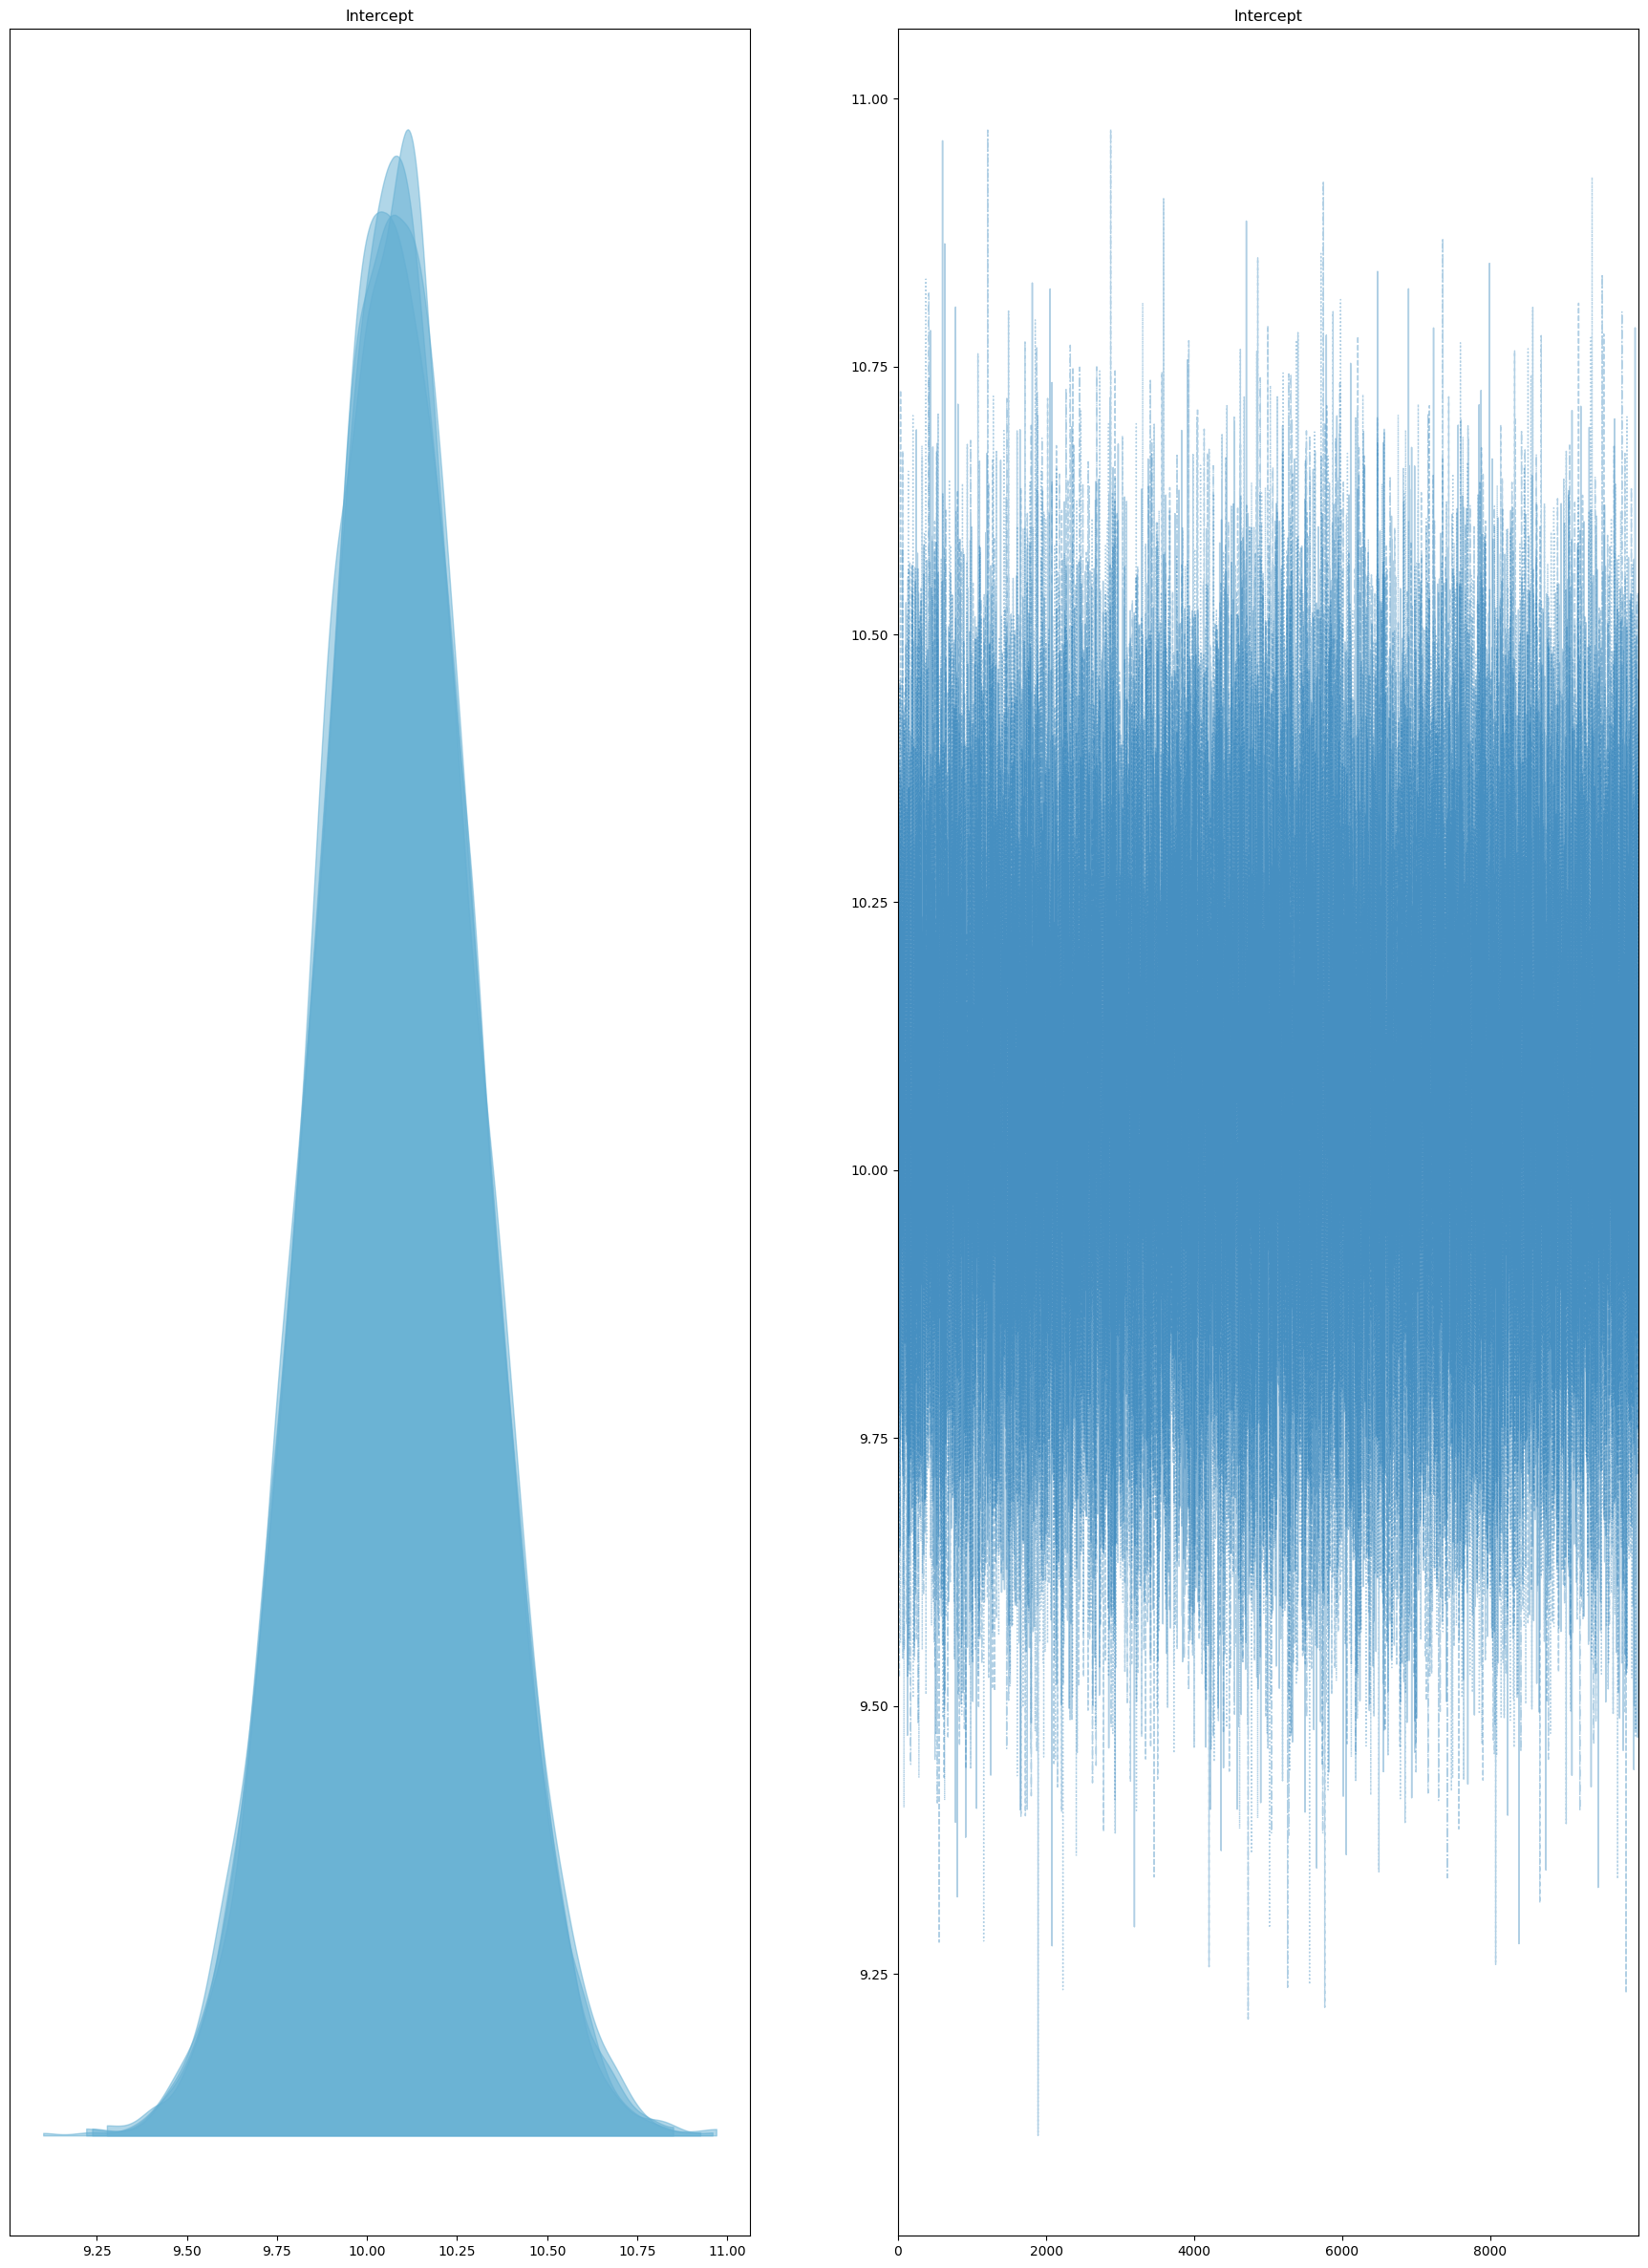

In [ ]:
axes = az.plot_trace(trace, var_names = 'Intercept',figsize=(22, 30), plot_kwargs={'alpha':0},fill_kwargs={'alpha': 0.5, 'color': '#63afd3'})


In [ ]:
list(trace.posterior.data_vars)

['Intercept',
 'NumTransfers',
 'Interaction Between NumCallouts and admit_type_EMERGENCY',
 'Interaction Between NumDiagnosis and NumTransfers',
 'Interaction Between NumChartEvents and admit_type_NEWBORN',
 'Interaction Between admit_type_NEWBORN and admit_location_CLINIC REFERRAL/PREMATURE',
 'Standard Deviation']

In [ ]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_samples = posterior_predictive.posterior_predictive

# Now, extract the predicted values for 'y'
y_pred_samples = posterior_predictive_samples['y']

# Calculate the probability that y > 2
prob_greater_than_2 = np.mean(y_pred_samples > 2)

print(f"The probability that y is greater than 2 is: {prob_greater_than_2:.3f}")

Sampling: [y]


Output()

The probability that y is greater than 2 is: 0.737


In [ ]:
# Step 2: Compute the condition (values > 2)
condition = y > 2

# Step 3: Calculate the probability
prob_greater_than_2 = condition.mean()

# Output the result
print(f"The probability that values in the column are greater than 2 is: {prob_greater_than_2:.3f}")

The probability that values in the column are greater than 2 is: 0.893


In [ ]:
dfy = pd.DataFrame(y)
len(dfy[dfy['LOSdays']>2]) / len(dfy)

0.8931451612903226